In [1]:
import torch
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. From Huggingface (https://huggingface.co/Links to an external site.) select and download a pre-trained CLIP model (you can use your own computer, Colab, Kaggle... to store the model). Describe the model you downloaded - what is its architecture (e.g. CNN/ViT), number of layers, parameters per layer - breakdown the parameters and explain what they are doing (e.g. are they parts of K, Q and V matrices, bias, feature maps, dense layer...).

In [4]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")
print(model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [5]:

# Function to analyze and print layer details
def analyze_model(model):
    total_params = 0
    breakdown = []

    for name, param in model.named_parameters():
        param_count = param.numel()  # Total number of parameters in the tensor
        total_params += param_count

        # Analyze the role of parameters based on their layer names
        if "vision_model" in name:
            component = "Vision Encoder (ViT)"
        elif "text_model" in name:
            component = "Text Encoder (Transformer)"
        elif "projection" in name:
            component = "Projection Layers"
        else:
            component = "Other"

        breakdown.append((name, param_count, component))

    return total_params, breakdown

# Analyze the model
total_parameters, parameter_breakdown = analyze_model(model)

# Display the results
print(f"Total Parameters in the Model: {total_parameters}")
print("\nBreakdown of Parameters by Layers:")

for name, count, component in parameter_breakdown:
    print(f"{name:70} | Parameters: {count:10} | Component: {component}")

# Optional: Group parameters by components for better summarization
from collections import defaultdict

component_summary = defaultdict(int)
for _, count, component in parameter_breakdown:
    component_summary[component] += count

print("\nSummary by Component:")
for component, count in component_summary.items():
    print(f"{component:25} | Total Parameters: {count}")

# Display learnable parameters count
learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nLearnable Parameters: {learnable_parameters}")



Total Parameters in the Model: 427616513

Breakdown of Parameters by Layers:
logit_scale                                                            | Parameters:          1 | Component: Other
text_model.embeddings.token_embedding.weight                           | Parameters:   37945344 | Component: Text Encoder (Transformer)
text_model.embeddings.position_embedding.weight                        | Parameters:      59136 | Component: Text Encoder (Transformer)
text_model.encoder.layers.0.self_attn.k_proj.weight                    | Parameters:     589824 | Component: Text Encoder (Transformer)
text_model.encoder.layers.0.self_attn.k_proj.bias                      | Parameters:        768 | Component: Text Encoder (Transformer)
text_model.encoder.layers.0.self_attn.v_proj.weight                    | Parameters:     589824 | Component: Text Encoder (Transformer)
text_model.encoder.layers.0.self_attn.v_proj.bias                      | Parameters:        768 | Component: Text Encoder (Trans

For the Assignment the CLIP model openai/clip-vit-large-patch14 from Hugging Face's model hub is being used. This model uses a Vision Transformer (ViT) for image encoding and a Transformer-based Text Encoder for processing text.

# ARCHITECTURE 
# Vision Transformer (ViT)
     - Purpose: Transforms images into a feature vector for representation.
     - Structure:
     - Patch Embedding: Splits an image into fixed-size patches (14×14 pixels) and maps each patch into a specific embedding space using a linear      projection.
     
# Transformer Layers: 
      - Processes the patch embeddings through a stack of 24 self-attention layers.
      - Output: Produces a unified feature vector representing the image.
      
# Text Transformer
      - Purpose: Converts text descriptions into a feature vector for representation.
      - Token Embedding: Maps each input token into an embedding space of dimension 768.
      - Output: Generates a single feature vector that encapsulates the meaning of the text.
    
# Projection Layers
      - Purpose: Maps the output embeddings of both the image and text into a shared vector space for alignment.
      - It includes two linear layers where one layer projects the image embeddings and the other layer projects the text embeddings.

# Parameter Breakdown of CLIP Model

## Vision Transformer (ViT)
- **Purpose**: Encodes images into feature vectors.
- **Number of Layers**: 24

| **Component**              | **Details**                       | **Parameters**      |
|----------------------------|-----------------------------------|---------------------|
| Patch Embedding            | Conv2D layer (14×14 patches)      | 602,112             |
| Positional Embedding       | Embeds 257 patches (256 + 1 class token) | 263,168         |
| Self-Attention (24 layers) | Q, K, V, Output Projection (1024→1024) | ~1,048,576 per layer |
| Feed-Forward (24 layers)   | MLP (1024→4096→1024)              | ~4,194,304 per layer |
| Layer Normalization        | Learnable weights and biases      | ~2,048 per layer     |
| **Total**                  | Total Vision Encoder Parameters   | 303,179,776         |

---

## Text Transformer
- **Purpose**: Encodes text descriptions into feature vectors.
- **Number of Layers**: 12

| **Component**              | **Details**                       | **Parameters**      |
|----------------------------|-----------------------------------|---------------------|
| Token Embedding            | Embeds 49,408 vocabulary tokens   | 37,945,344          |
| Positional Embedding       | Embeds 77 positions               | 59,136              |
| Self-Attention (12 layers) | Q, K, V, Output Projection (768→768) | ~589,824 per layer |
| Feed-Forward (12 layers)   | MLP (768→3072→768)                | ~2,359,296 per layer |
| Layer Normalization        | Learnable weights and biases      | ~1,536 per layer     |
| **Total**                  | Total Text Encoder Parameters     | 123,060,480         |

---

## Projection Layers
- **Purpose**: Aligns the text and image embeddings into a shared space.

| **Component**              | **Details**                       | **Parameters**      |
|----------------------------|-----------------------------------|---------------------|
| Text Projection            | Linear Layer (768→768)            | 589,824             |
| Visual Projection          | Linear Layer (1024→768)           | 786,432             |
| **Total**                  | Total Projection Layer Parameters | 1,376,256           |

---

## Total Parameters

| **Component**              | **Parameters**         |
|----------------------------|------------------------|
| Vision Transformer (ViT)   | 303,179,776           |
| Text Transformer           | 123,060,480           |
| Projection Layers          | 1,376,256             |
| **Total**                  | **427,616,513**       |




# 2. The dataset contains images from the following eight categories: airplane, car, chair, cup, dog, donkey, duck and hat. Each category contains images in five different conditions: realistic, geons, silhouettes, blured and features. Evaluate the model for each condition separately. For each image in the dataset, feed the image into the model together with a text label of a particular category (for each image, evaluate labels of all eight categories). If the model outputs highest correlation for the correct label, consider that as correct classification and otherwise as incorrect classification. Quantify model accuracy for each of the five conditions.

In [8]:
import zipfile
import os

archive_path = "image_files.zip"  
output_folder = "extracted_images" 

if zipfile.is_zipfile(archive_path):
    with zipfile.ZipFile(archive_path, mode="r") as archive:
        archive.extractall(output_folder)
    print(f"Contents have been extracted to: {output_folder}")
    
    extracted_files = os.listdir(output_folder)
    print("Extracted files:", extracted_files)
else:
    print(f"Error: '{archive_path}' is not recognized as a valid ZIP file.")


Contents have been extracted to: extracted_images
Extracted files: ['image_files']


In [9]:
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch

model_identifier = "openai/clip-vit-large-patch14"  # You can change to another CLIP model if needed
clip_model = CLIPModel.from_pretrained(model_identifier)
clip_processor = CLIPProcessor.from_pretrained(model_identifier)

# Define categories and image conditions
labels = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions_list = ["geons", "silhouettes", "blurred", "features", "realistic"]

# Path to the dataset containing image files
data_directory = "images/image_files/v0"

# Function to process and evaluate a single image
def process_single_image(image_path, true_label):
    # Open and convert the image to RGB
    img = Image.open(image_path).convert("RGB")

    # Create input tensors for image and text labels
    input_data = clip_processor(
        text=labels,  # Use all categories for comparison
        images=img,
        return_tensors="pt",
        padding=True
    )

    predictions = clip_model(**input_data)
    logits = predictions.logits_per_image  
    probabilities = logits.softmax(dim=1)  

    predicted_index = torch.argmax(probabilities).item()
    predicted_label = labels[predicted_index]

    return predicted_label == true_label

def compute_accuracy(data_directory, conditions_list, labels):
    condition_accuracies = {}

    # Loop through each condition (e.g., geons, blurred)
    for condition in conditions_list:
        correct_predictions = 0
        total_images = 0

        condition_dir = os.path.join(data_directory, condition)

        # Process images in the folder for this condition
        for img_file in os.listdir(condition_dir):
            for label in labels:
                if label.lower() in img_file.lower():  # Match category with file name
                    img_path = os.path.join(condition_dir, img_file)
                    is_prediction_correct = process_single_image(img_path, label)
                    correct_predictions += is_prediction_correct
                    total_images += 1

        condition_accuracies[condition] = (
            correct_predictions / total_images if total_images > 0 else 0.0
        )
        print(f"Total images evaluated for {condition}: {total_images}")

    return condition_accuracies

evaluation_results = compute_accuracy(data_directory, conditions_list, labels)

# Display the evaluation results
print("\nModel Accuracy by Condition:")
for condition, accuracy in evaluation_results.items():
    print(f"{condition.capitalize()}: {accuracy:.2%}")


Total images evaluated for geons: 59
Total images evaluated for silhouettes: 40
Total images evaluated for blurred: 42
Total images evaluated for features: 41
Total images evaluated for realistic: 41

Model Accuracy by Condition:
Geons: 55.93%
Silhouettes: 92.50%
Blurred: 85.71%
Features: 90.24%
Realistic: 100.00%


The dataset contains categories airplane, car, chair, cup, dog, donkey, duck, hat and conditions realistic, geons, silhouettes, blurred, features where each image in a given condition was paired with text labels corresponding to all eight categories. The model evaluated 59, 40, 42, 41, 41 of geons, silhouettes, blurred, features and realistic with an accuracy of 55.93%, 92.50%, 85.71%, 90.24%, and 100% respectively.
CONCLUSION:
* Realistic Condition: Achieved perfect accuracy from which it can be concluded that the model is able to classify images that closely resemble real-world objects.
* Geons Condition: Performed the worst with an accuracy of 55.93%. This suggests that simplified geometric shapes are challenging for the model to classify correctly.
* Silhouettes, Blurred, and Features: All conditions showed high accuracy, with silhouettes achieving 92.50%, which shows the model is good at recognizing objects even when only their outlines are visible.


# In which conditions is your models better/worse/similar to babies (Fig. 3A in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site.)? 

In [20]:
model_accuracy = [evaluation_results[condition] for condition in conditions_list]


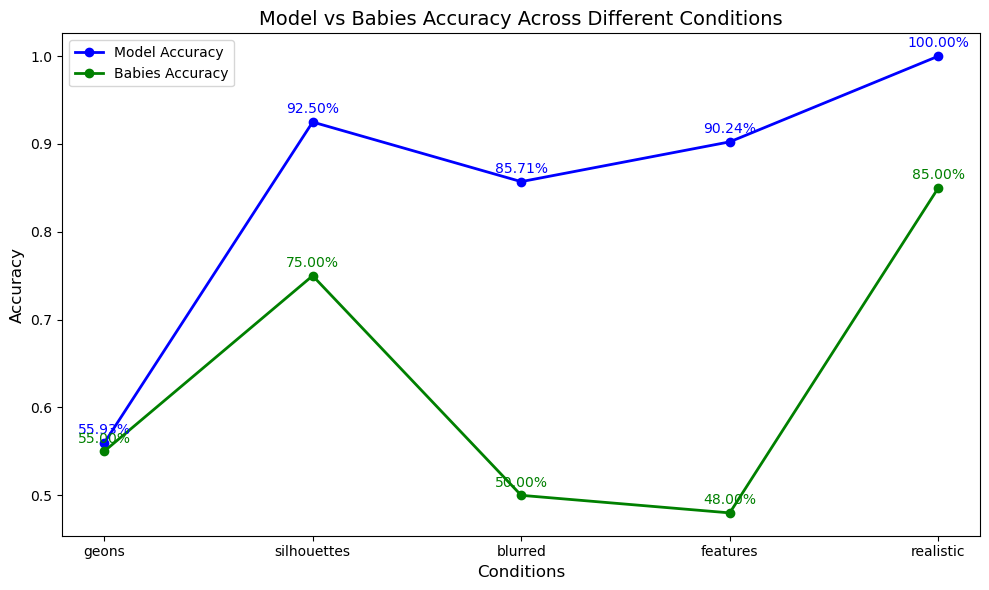


Model Accuracy by Condition:
Geons: 55.93%
Silhouettes: 92.50%
Blurred: 85.71%
Features: 90.24%
Realistic: 100.00%


In [28]:
import matplotlib.pyplot as plt
model_accuracy = [evaluation_results[condition] for condition in conditions_list]
babies_accuracy = [0.55, 0.75, 0.50, 0.48, 0.85]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(conditions_list, model_accuracy, marker='o', label='Model Accuracy', color='b', linewidth=2)
ax.plot(conditions_list, babies_accuracy, marker='o', label='Babies Accuracy', color='g', linewidth=2)
ax.set_xlabel('Conditions', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model vs Babies Accuracy Across Different Conditions', fontsize=14)
ax.legend()
for i, acc in enumerate(model_accuracy):
    ax.text(i, model_accuracy[i] + 0.01, f'{acc:.2%}', ha='center', color='b')
for i, acc in enumerate(babies_accuracy):
    ax.text(i, babies_accuracy[i] + 0.01, f'{acc:.2%}', ha='center', color='g')
plt.xticks(range(len(conditions_list)), conditions_list, fontsize=10)
plt.tight_layout()
plt.show()
print("\nModel Accuracy by Condition:")
for condition, accuracy in evaluation_results.items():
    print(f"{condition.capitalize()}: {accuracy:.2%}")


Model Performance based on graph : 

- The model consistently outperforms babies in all conditions.
- It achieves the highest accuracy of 100% in the realistic condition while babies achieve 85%.
- For silhouettes the model achieves 92.5% which is significantly higher than the 75% accuracy of babies.
  
Conditions Where the Model Performs Better:

- Silhouettes (92.5% vs. 75%): The model handles object outlines much better.
- Blurred (85.71% vs. 50%): The model performs well even with reduced visual clarity.
- Features (90.24% vs. 48%): The model shows strong robustness to partial visual cues.
- Realistic (100% vs. 85%): The model performs perfectly when the visual input is closest to reality.
- Geons: Both the model and babies perform similarly, with the model at 55.93% and babies at 55%. This indicates that both struggle with abstract, simplified object representations.

# 3. From the output of the final layer of the vision encoder (before the projection layer into the shared embedding space) take embeddings for each image in the dataset. Apply t-SNE to those embeddings and plot them in a 2D space - plot little images of objects in the embedding space (something like Fig. 4 in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site. but no need for color coding of bounding boxes).

Performing t-SNE dimensionality reduction...


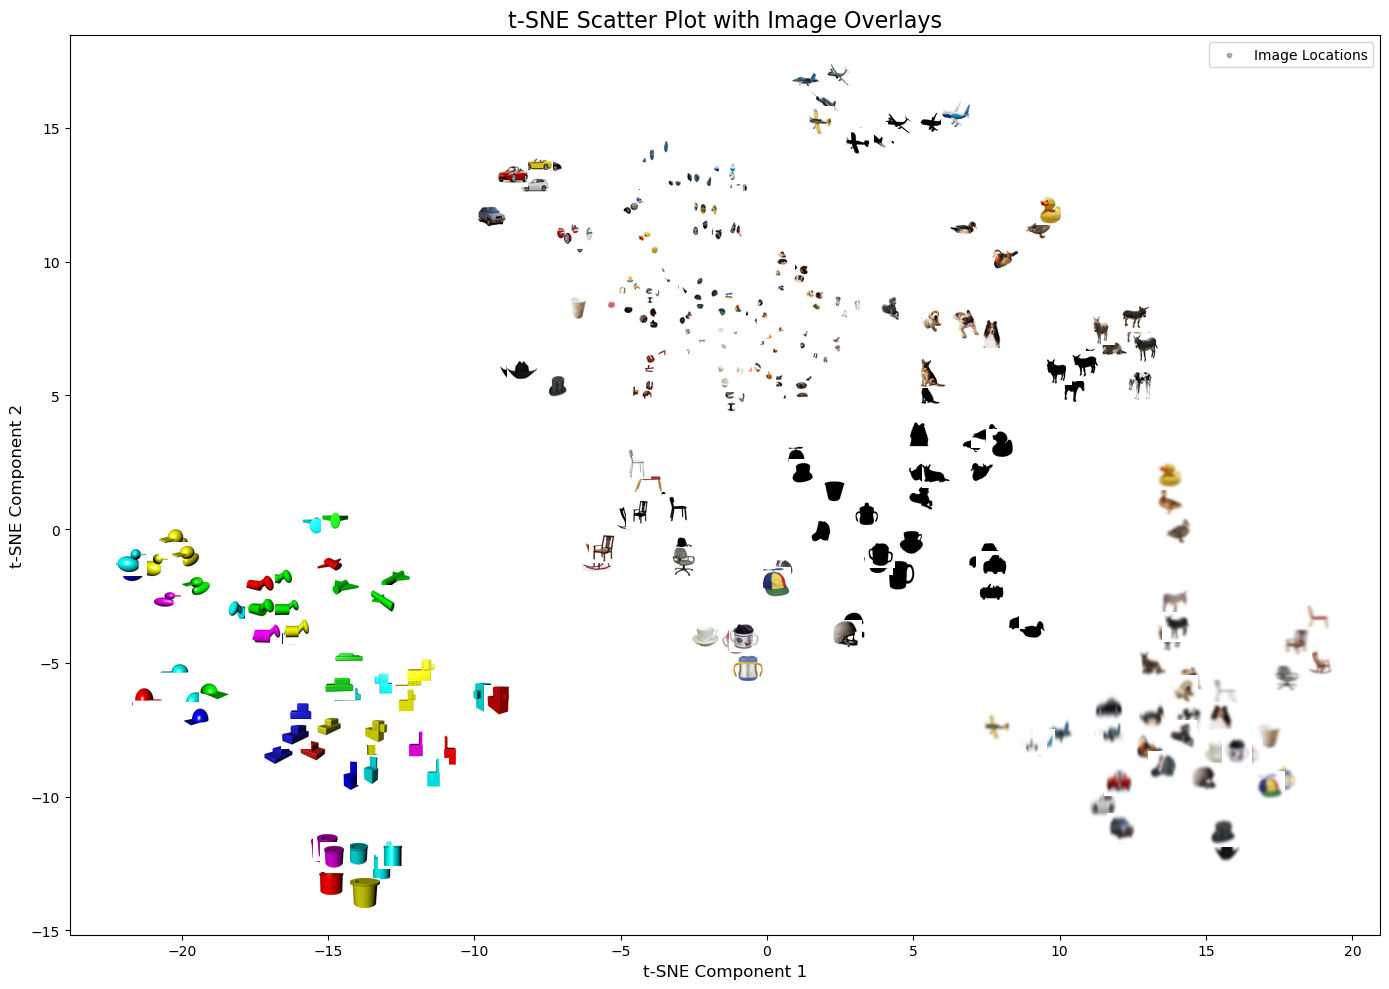

In [30]:
from sklearn.manifold import TSNE
import numpy as np
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

def compute_image_embeddings(folder_path):
    folder_full_path = os.path.join(data_directory, folder_path)  # Full path for the condition
    image_embeddings = []
    loaded_images = []

    for file in os.listdir(folder_full_path):
        file_path = os.path.join(folder_full_path, file)

        if os.path.isfile(file_path):  # Ensure it's a file
            img = Image.open(file_path).convert("RGB")

            # Generate embeddings using the CLIP processor
            input_data = clip_processor(images=img, return_tensors="pt", padding=True)
            with torch.no_grad():
                output = clip_model.vision_model(**input_data)
                avg_embedding = output.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

            image_embeddings.append(avg_embedding)
            loaded_images.append(img)

    return np.array(image_embeddings), loaded_images

all_image_embeddings = []
all_condition_images = []

for condition_name in conditions_list:  # Loop through each condition
    embeddings, images = compute_image_embeddings(condition_name)
    all_image_embeddings.append(embeddings)
    all_condition_images.extend(images)

# Combine all embeddings into a single array
all_image_embeddings = np.vstack(all_image_embeddings)

print("Performing t-SNE dimensionality reduction...")
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_coordinates = tsne_model.fit_transform(all_image_embeddings)

def scatter_plot_with_images(tsne_points, image_list, output_filename="scatter_tsne.png"):
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot the t-SNE points as a scatter plot
    ax.scatter(tsne_points[:, 0], tsne_points[:, 1], s=10, color="gray", alpha=0.6, label="Image Locations")

    # Overlay images at their respective t-SNE coordinates
    for img, (x, y) in zip(image_list, tsne_points):
        image_offset = OffsetImage(img.resize((30, 30)), zoom=0.7)
        annotation = AnnotationBbox(image_offset, (x, y), frameon=False)
        ax.add_artist(annotation)

    # Add plot details
    ax.set_title("t-SNE Scatter Plot with Image Overlays", fontsize=16)
    ax.set_xlabel("t-SNE Component 1", fontsize=12)
    ax.set_ylabel("t-SNE Component 2", fontsize=12)
    plt.legend()
    plt.tight_layout()

    # Save and display the plot
    plt.savefig(output_filename)
    plt.show()

scatter_plot_with_images(tsne_coordinates, all_condition_images)


From the t-SNE visualization of the image embeddings, we can conclude the following : 

- Realistic objects like animals such as duck, donkeys form distinct clusters in the upper-right region.
- Simplified representations like silhouettes and geons appear clustered together, particularly in the middle-left and bottom-left areas.
- Geons and silhouettes appear more tightly clustered in distinct regions, likely because they share fewer details compared to realistic images.
- The Vision Transformer (ViT)-based CLIP model effectively captures visual features from complex and simple object representations.
- It maintains a strong ability to distinguish even highly abstract representations like silhouettes and geons, which is reflected in their separation.
- Objects belonging to the same category, such as cups, chairs, or animals, are grouped together. This indicates that the model understands semantic similarities in the images and maps them to close points in the embedding space.

The embedding space learned by the model organizes the images in a meaningful and hierarchical way.
Realistic and detailed images dominate the space, while abstract representations (geons, silhouettes) are still recognized but clustered more compactly.